
*********** Calculating GR for mode 1

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 2

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 3

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 4

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...
Checking modes 1 and 2...
                start mode                 end     dt  d_initial    d_final  \
0 2017-12-31 01:40:00   m2 2017-12-31 04:50:00  190.0      48.88  51.450000   
1 2017-12-31 06:00:00   m2 2017-12-31 06:40:00   40.0      49.00  51.450000   
2 2017-12-31 06:50:00   m2 2017-12-31 07:50:00   60.0      51.45  51.450000   
3 2017-12-31 08:00:00   m2 2017-12-31 09:00:00   60.0      51.45  47.370787   
4 2017-12-31 09:10:00   m2 2017

/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


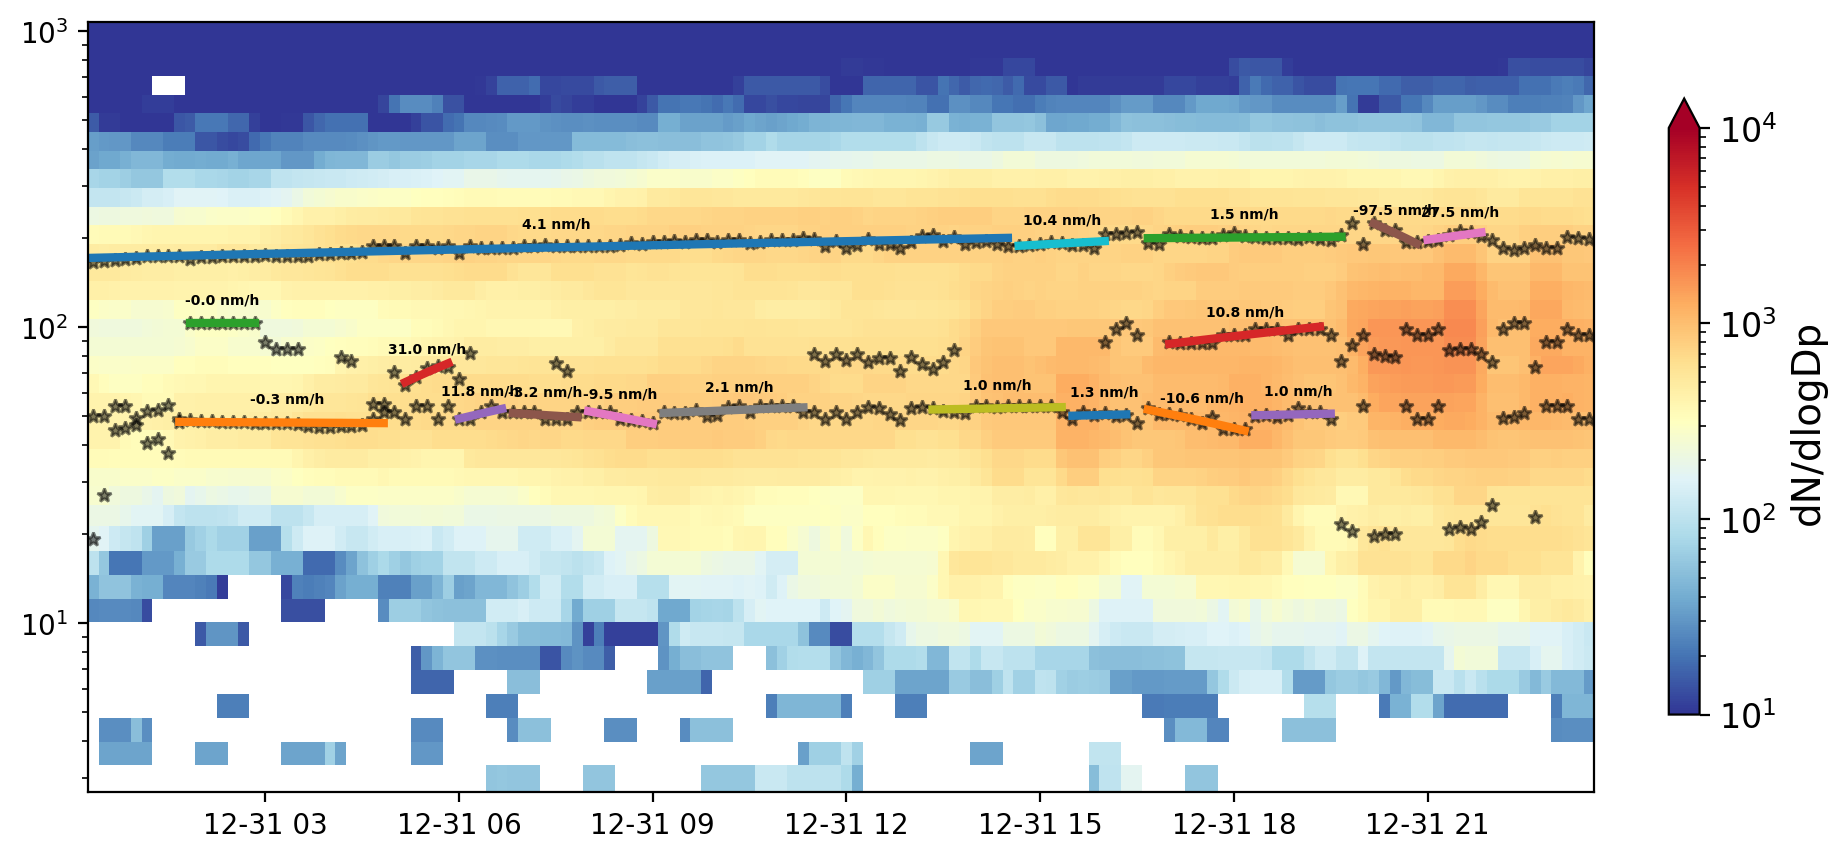

In [1]:
# 12 Sep (NEW Check 2) Nesrine (Original Code) 1 day (Checked nesrine code and applied on my PSD Vs TOL data)




# -*- coding: utf-8 -*-
"""
Created on Tue May  7 19:54:10 2024

@author: unfer
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
from matplotlib import colors
from datetime import timedelta
from datetime import datetime
from scipy.optimize import curve_fit, OptimizeWarning 
import warnings
from scipy import stats
import os ###
from os import listdir ###

###################################################################
paths = "/Users/touqeergill/Desktop/dm171231.sum"
dados1= pd.read_csv(paths,sep='\s+',engine='python') ###steps to '\s+'
df1 = pd.DataFrame(dados1)
#dm160405.sum

"""
###ADDED
#user gives the amount of data files to plot and starting day
#assumes data files are in chronological order in the folder with consecutive days
def input_data():
    paths_list = []
    
    amount = input("How many days of data (number): ")
    file_name = input("Name of first data file: ")

    counter = 0
    for name in sorted(listdir(folder)):
        if name == file_name:
            paths_list.append(file_name)
            counter += 1
            continue
        elif counter > 0 and counter < int(amount):
            paths_list.append(name)
            counter += 1
            continue
        else:
            continue
    return paths_list
paths = input_data()

###modified from Janne's code "NpfEventAnalyzer.py":
### load data for n days: ###
def combine_data():
    dfs = []
    test = True
    #load all given data files and save them a list
    for i in paths:
        df = pd.DataFrame(pd.read_csv(folder + i,sep='\s+',engine='python'))
        #make sure all columns have the same diameter values, name all other columns with the labels of the first one
        if test == True:
            diameter_labels = df.columns
            test = False
        df.rename(columns=dict(zip(df.columns, diameter_labels)), inplace=True)
        dfs.append(df) #add dataframe to list
    #combine datasets
    combined_data = pd.concat(dfs,axis=0,ignore_index=True)
    return combined_data
df1 = combine_data()
"""
###----

diameters = df1.columns[2:].astype(float)*10**9 ### save diameters as floats before replacing them with new column names / units from m to nm
df1.columns = ["time (d)", "total number concentration (N)"] + [f"dN/dlogDp_{i}" for i in range(1,df1.shape[1]-1)] ###rename columns
time_d = df1.iloc[:,0].astype(float) ###ADDED save time as days before changing them to UTC 

### assuming time is in "days from start of measurement"
def days_into_UTC():
    time_steps = df1["time (d)"] - time_d[0]
    start_date_measurement = f"20{paths[-10:-8]}-{paths[-8:-6]}-{paths[-6:-4]} 00:00:00"
    start_date = datetime.strptime(start_date_measurement, "%Y-%m-%d %H:%M:%S")
    df1["time (d)"] = [start_date + timedelta(days=i) for i in time_steps] #converting timesteps to datetime
days_into_UTC() ###

df1.rename(columns={'time (d)': 'Timestamp (UTC)'}, inplace=True) ###CHANGE '# "datetime (UTC)"' -> 'time (d)'
df1['Timestamp (UTC)']=pd.to_datetime(df1['Timestamp (UTC)'], format="%Y-%m-%d %H:%M:%S")
df1.index=df1['Timestamp (UTC)']
df1 = df1.drop(['Timestamp (UTC)'], axis=1)


df1[(df1<0)] = 0                     ## Treat negative data as zero
df1[(df1.sum(axis=1)==0)] = np.nan   ## Discart a whole zero size distribution
df1 = df1.dropna()

df1 = df1.resample('10Min').mean().interpolate(method='time', limit_area='inside', limit=6) ###CHANGE 5Min -> 10Min CHECK FROM HERE UP

N_tot = list(df1["total number concentration (N)"]) ### save total number concentrations to a list
df1 = df1.drop(['total number concentration (N)'], axis=1) ### drop N_tot from the dataframe
#df1['N_tot'] = (df1.sum(axis=1)*0.0265) ### commented away
#df1[df1['N_tot']>df1['N_tot'].quantile(0.999)] = np.nan  ### commented away
#df1 = df1.dropna() ### commented away
#df1 = df1.drop(['N_tot'], axis=1) ### commented away
df1.columns = pd.to_numeric(diameters) ### rename columns back to diameters

### median filter
for i in df1.columns:
    #df1[i] = df1[i].rolling(window=3, center=True).median() ### window of 3 datapoints i.e. 1 neighbouring value
    df1[i] = df1[i].rolling(window=5, center=True).median() ### window of 5 datapoints i.e. 2 neighbouring value
df1.dropna(inplace=True)

#with this we can check the format
df1.to_csv('./combined_data.csv', sep=',', header=True, index=True, na_rep='nan')

##############################################################

path4=r"/Users/touqeergill/Desktop/output_modefit_2017_12.csv"
dados4= pd.read_csv(path4,sep=',')
df4 = pd.DataFrame(dados4)

df4.index = pd.to_datetime(df4['Timestamp (UTC)'])
df4 = df4.drop(['Timestamp (UTC)'],axis=1)
df4 = df4.drop(['flag'],axis=1)
df4 = df4.astype(float)

#df4[(df4['R2']<0.7)] = np.nan ### 0.8 -> 0.7 COMMENTED AWAY, filters away mode fitting values that dont have a high enough r^2 value


##############################################################
def place_modes(row):
    if row['m1_d'] >= 20 and row['m2_A'] == 0:
        row['m2_A'], row['m2_d'], row['m2_s'] = row['m1_A'], row['m1_d'], row['m1_s']
        row['m1_A'], row['m1_d'], row['m1_s'] = 0, 10, 1.1

    if row['m2_d'] < 20 and row['m1_A'] == 0:
        row['m1_A'], row['m1_d'], row['m1_s'] = row['m2_A'], row['m2_d'], row['m2_s']
        row['m2_A'], row['m2_d'], row['m2_s'] = 0, 20, 1.1

    if row['m3_d'] < 50 and row['m2_A'] == 0:
        row['m2_A'], row['m2_d'], row['m2_s'] = row['m3_A'], row['m3_d'], row['m3_s']
        row['m3_A'], row['m3_d'], row['m3_s'] = 0, 50, 1.1
        
    if row['m3_d'] > 100 and row['m4_A'] == 0:
        row['m4_A'], row['m4_d'], row['m4_s'] = row['m3_A'], row['m3_d'], row['m3_s']
        row['m3_A'], row['m3_d'], row['m3_s'] = 0, 50, 1.1

    return row

df4 = df4.apply(place_modes, axis=1)


def replace_zero_with_nan(row):
    for i in range(1, 5):  
        if row[f'm{i}_A'] == 0.00:
            row[f'm{i}_A'] = np.nan
            row[f'm{i}_d'] = np.nan
            row[f'm{i}_s'] = np.nan
    return row

df4 = df4.apply(replace_zero_with_nan, axis=1)
df_modes = df4.copy()

########################################################################
###### CMAP
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

R = [255,0,5,12,28,46,74,107,144,193,229,249,255,253,246]
G = [250,116,175,184,149,107,57,36,28,24,37,80,140,205,244]
B = [250,163,227,246,218,161,89,52,39,29,26,25,27,21,63]

cdict = {
    'red':((0.0,inter_from_256(R[0]),inter_from_256(R[0])),
           (1/14*1,inter_from_256(R[1]),inter_from_256(R[1])),
           (1/14*2,inter_from_256(R[2]),inter_from_256(R[2])),
           (1/14*3,inter_from_256(R[3]),inter_from_256(R[3])),
           (1/14*4,inter_from_256(R[4]),inter_from_256(R[4])),
           (1/14*5,inter_from_256(R[5]),inter_from_256(R[5])),
           (1/14*6,inter_from_256(R[6]),inter_from_256(R[6])),
           (1/14*7,inter_from_256(R[7]),inter_from_256(R[7])),
           (1/14*8,inter_from_256(R[8]),inter_from_256(R[8])),
           (1/14*9,inter_from_256(R[9]),inter_from_256(R[9])),
           (1/14*10,inter_from_256(R[10]),inter_from_256(R[10])),
           (1/14*11,inter_from_256(R[11]),inter_from_256(R[11])),
           (1/14*12,inter_from_256(R[12]),inter_from_256(R[12])),
           (1/14*13,inter_from_256(R[13]),inter_from_256(R[13])),
           (1.0,inter_from_256(R[14]),inter_from_256(R[14]))),
    'green': ((0.0,inter_from_256(G[0]),inter_from_256(G[0])),
           (1/14*1,inter_from_256(G[1]),inter_from_256(G[1])),
           (1/14*2,inter_from_256(G[2]),inter_from_256(G[2])),
           (1/14*3,inter_from_256(G[3]),inter_from_256(G[3])),
           (1/14*4,inter_from_256(G[4]),inter_from_256(G[4])),
           (1/14*5,inter_from_256(G[5]),inter_from_256(G[5])),
           (1/14*6,inter_from_256(G[6]),inter_from_256(G[6])),
           (1/14*7,inter_from_256(G[7]),inter_from_256(G[7])),
           (1/14*8,inter_from_256(G[8]),inter_from_256(G[8])),
           (1/14*9,inter_from_256(G[9]),inter_from_256(G[9])),
           (1/14*10,inter_from_256(G[10]),inter_from_256(G[10])),
           (1/14*11,inter_from_256(G[11]),inter_from_256(G[11])),
           (1/14*12,inter_from_256(G[12]),inter_from_256(G[12])),
           (1/14*13,inter_from_256(G[13]),inter_from_256(G[13])),
           (1.0,inter_from_256(G[14]),inter_from_256(G[14]))),
    'blue': ((0.0,inter_from_256(B[0]),inter_from_256(B[0])),
           (1/14*1,inter_from_256(B[1]),inter_from_256(B[1])),
           (1/14*2,inter_from_256(B[2]),inter_from_256(B[2])),
           (1/14*3,inter_from_256(B[3]),inter_from_256(B[3])),
           (1/14*4,inter_from_256(B[4]),inter_from_256(B[4])),
           (1/14*5,inter_from_256(B[5]),inter_from_256(B[5])),
           (1/14*6,inter_from_256(B[6]),inter_from_256(B[6])),
           (1/14*7,inter_from_256(B[7]),inter_from_256(B[7])),
           (1/14*8,inter_from_256(B[8]),inter_from_256(B[8])),
           (1/14*9,inter_from_256(B[9]),inter_from_256(B[9])),
           (1/14*10,inter_from_256(B[10]),inter_from_256(B[10])),
           (1/14*11,inter_from_256(B[11]),inter_from_256(B[11])),
           (1/14*12,inter_from_256(B[12]),inter_from_256(B[12])),
           (1/14*13,inter_from_256(B[13]),inter_from_256(B[13])),
           (1.0,inter_from_256(B[14]),inter_from_256(B[14]))),
}

cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)
########################################################################

def calculate_slope(x, y):
    try:
        slope = np.polyfit(x, y, 1)[0]
        return slope
    except np.linalg.LinAlgError:
        return np.nan

def check_time_gaps(indices, max_gap_minutes):
    time_gaps = indices.to_series().diff()
    return (time_gaps > timedelta(minutes=max_gap_minutes)).any()

def fit_curve(data):
    def linear(x, m, b):
        return m * x + b
    x = np.arange(len(data))
    y = data.values
   
    try:
        popt, _ = curve_fit(linear, x, y)
        return linear, popt
    except:
        return None, None
    
###############################################

def find_segments(df,abr):
    segments = []
    timestamps = df.index
    
    for i in range(0, len(timestamps), 1):
        segments.append((timestamps[i]))
 
    return segments    

##################################################

def combine_segments(df, abr, segments, mape_threshold=2):
    combined_segments = []
    start = 0

    while start < len(segments):
        end = start + 1
        while end < len(segments):
            if end >= len(segments):
                break
            
            comb_segs_data = df[abr + '_d'].loc[segments[start]:segments[end]]
            time_difference = segments[end] - segments[end - 1]
            if time_difference != timedelta(minutes=10): ###checks if the time difference is not 5mins!!! CHANGED: timedelta(minutes=5) -> timedelta(minutes=10)
                break
            
            x_comb = np.arange(len(comb_segs_data))
            y_comb = comb_segs_data.values
            #print(comb_segs_data)
            curve, popt = fit_curve(comb_segs_data)
            y_fit = curve(x_comb, *popt)
            erros_absolutos = np.abs(y_fit - y_comb)
            mape = np.mean(erros_absolutos / y_comb) * 100
            
            if mape > mape_threshold:
                break
                       
            end += 1
              
        if len (comb_segs_data) == 3 and mape > mape_threshold:
            start = end-1
        else:           
            combined_segments.append((segments[start], segments[min(end-1, len(segments)-1)]))
            start = end 
        
    return combined_segments

###################################################

def filter_segments(df, abr, combined_segments):
    filtered_segments = []
    for segment in combined_segments:
        
        data = df[abr + '_d'].loc[segment[0]:segment[1]]
              
        if len(data) >= 5 and not check_time_gaps(df.loc[segment[0]:segment[1]].index, 120):
                
            curve, popt = fit_curve(data)
            if curve is not None and popt is not None:
                x_values = np.arange(len(data))
                y_values = data.values
                erros_absolutos = np.abs(curve(x_values, *popt) - y_values)
                mape = np.mean(erros_absolutos / y_values) * 100

                if mape <= 10:
                    filtered_segments.append(segment)
    return filtered_segments

########################

def process_data(df, abr):
    results = []

    df_subset = df[[abr + '_A', abr + '_d', abr + '_s']].copy()
    df_subset = df_subset.dropna()
  
    segs = find_segments(df_subset,abr)
    print('Segments done! (1/3)')
    comb_segs = combine_segments(df_subset, abr, segs)
    print('Combined segments done! (2/3)')
    filter_segs = filter_segments(df_subset, abr, comb_segs)
    print('Filtering done! (3/3)')
    results.append(filter_segs)    
 
    return df_subset, results

def extract_data (df_subset, results, abr):   
    print('Extracting dataframe...')
    lista = []
    segment_data = []
    fitted_curves = []

    for segment in results[0]:
       
        start = segment[0]
        end = segment[1]
        dt = ((end - start).total_seconds()) / 60
        
        d_initial = df_subset[abr + '_d'].loc[start]
        d_final = df_subset[abr + '_d'].loc[end]
        data = df_subset[abr + '_d'].loc[start:end]
        d_mean = data.mean()
        mean_A = df_subset[abr + '_A'].loc[start:end].mean()
        mean_s = df_subset[abr + '_s'].loc[start:end].mean()

        curve, popt = fit_curve(data)
        GR = popt[0] * 12 
        lista.append([start, end, dt, d_initial, d_final, round(d_mean,1), round(mean_A,2), round(mean_s,3), round(GR, 1)])
        segment_data.append(data)
        fitted_curves.append((curve, popt))
    
    df_GR = pd.DataFrame(lista)
    if len(df_GR)==0:
        pass
    else:      
        df_GR.rename(columns={0: 'start', 1: 'end', 2: 'dt', 3: 'd_initial', 4: 'd_final', 5: 'mean_d', 6: 'mean_A', 7: 'mean_s', 8: 'GR'}, inplace=True)
        df_GR.index = df_GR['start']
        df_GR = df_GR.drop(['start'],axis=1)
    return df_GR, segment_data, fitted_curves

###############################################################################

def plot(*args):
    fig, ax = plt.subplots(figsize=(12, 3), dpi=300)
    x = df1.index[0:]
    #y = df1.columns.astype(float) ### 
    y = diameters ###
    plt.pcolormesh(x, y, df1[0:].T, cmap='RdYlBu_r', zorder=0, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
    ax.set_yscale('log')
    cbar = plt.colorbar(orientation='vertical', shrink=0.8, extend="max", pad=0.04)
    cbar.set_label('dN/dlogDp', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    for i in range(0, len(args), 4):
        abr = args[i]
        #df_GR = args[i + 1]
        segment_data = args[i + 2]
        fitted_curves = args[i + 3]
        
        if len(segment_data) > 0:  # Checks for segment data
            print("\nMode "+abr)
            plt.plot(df_modes.index, df_modes[abr + '_d'], '*', alpha=0.5, color='black', markersize=5)
        
        for j, data in enumerate(segment_data):
            if len(data) > 2:
                curve, popt = fitted_curves[j]
                if curve:
                    slope = round((popt[0] * 12), 1)
                    print(f"Segment {j + 1}: {slope} nm/h")
                    x_values = np.arange(len(data))
                    plt.plot(data.index, curve(x_values, *popt), lw=3)
               
                    midpoint_idx = len(data) // 2
                    midpoint_time = data.index[midpoint_idx]
                    midpoint_value = curve(midpoint_idx, *popt)
                    
                    plt.annotate(f'{slope} nm/h', (midpoint_time, midpoint_value), 
                                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, fontweight='bold')              
                else:
                    plt.plot(data.index, data, lw=3)
    
    plt.show()

############################################################################################

abr1 = 'm1'
print('\n'+'*********** Calculating GR for mode 1'+'\n')
df_subset_m1, results_m1 = process_data(df_modes, abr1)
df_GR_m1, segment_data_m1, fitted_curves_m1 = extract_data (df_subset_m1, results_m1, abr1)
#print(df_GR_m1)      ###

#df_GR_m1.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode1_nucl_data_v3.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1) # !!! Warning: make plots only for events or short dataset 

abr2 = 'm2'
print('\n'+'*********** Calculating GR for mode 2'+'\n')
df_subset_m2, results_m2 = process_data(df_modes, abr2)
df_GR_m2, segment_data_m2, fitted_curves_m2 = extract_data (df_subset_m2, results_m2, abr2)
#print(df_GR_m2)     ###
# df_GR_m2.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode2_ait1_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr2, df_GR_m2, segment_data_m2, fitted_curves_m2) # !!! Warning: make plots only for events or short dataset
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,abr2, df_GR_m2, segment_data_m2, fitted_curves_m2)

abr3 = 'm3'
print('\n'+'*********** Calculating GR for mode 3'+'\n')
df_subset_m3, results_m3 = process_data(df_modes, abr3)
df_GR_m3, segment_data_m3, fitted_curves_m3 = extract_data (df_subset_m3, results_m3, abr3)
#print(df_GR_m3)     ###
#df_GR_m3.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode3_ait2_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr3, df_GR_m3, segment_data_m3, fitted_curves_m3) # !!! Warning: make plots only for events or short dataset
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,abr2, df_GR_m2, segment_data_m2, fitted_curves_m2,abr3, df_GR_m3, segment_data_m3, fitted_curves_m3)

abr4 = 'm4'
print('\n'+'*********** Calculating GR for mode 4'+'\n')
df_subset_m4, results_m4 = process_data(df_modes, abr4)
df_GR_m4, segment_data_m4, fitted_curves_m4 = extract_data (df_subset_m4, results_m4, abr4)
#print(df_GR_m4)      ###
#df_GR_m4.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode4_acc_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr4, df_GR_m4, segment_data_m4, fitted_curves_m4) # !!! Warning: make plots only for events or short dataset
# plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,
#       abr2, df_GR_m2, segment_data_m2, fitted_curves_m2,
#       abr3, df_GR_m3, segment_data_m3, fitted_curves_m3,
#       abr4, df_GR_m4, segment_data_m4, fitted_curves_m4)


############################################################################################
def drop_after_first_nan(df, column):
    """Drops rows after the first occurrence of NaN in a specific column."""
    first_nan_index = df[column].isna().idxmax()
    if pd.isna(df[column].loc[first_nan_index]):
        return df.loc[:first_nan_index].iloc[:-1]
    return df


def process_data2(dfA, m1, dfB, m2, diameter_diff):
    lista = []
    listaA_del = []
    listaB_del = []
 
    for j in range(0,len(dfA)):
        start1 = dfA.index[j]
        end1 = dfA['end'].iloc[j]   # !!!
               
        df_m1 = df_modes.loc[start1:end1, [m1+'_A', m1+'_d', m1+'_s']]
        df_m1.columns = ['m_A', 'm_d', 'm_s']
    
        start_target = dfA['end'].iloc[j] + pd.Timedelta(minutes=10) ### minutes=5 -> minutes=10
        #print(start_target)
        if start_target in dfB.index.values:
            #print(start_target)
            
            idx_position = dfB.index.get_loc(start_target)
            
            if (dfB['d_initial'].iloc[idx_position] - dfA['d_final'].iloc[j]) < diameter_diff:
            
                start2 = dfB.index[idx_position]       # !!!
                end2 = dfB['end'].iloc[idx_position]
                df_m2 = df_modes.loc[start2:end2, [m2+'_A', m2+'_d', m2+'_s']]
                df_m2.columns = ['m_A', 'm_d', 'm_s']
                         
                df_comb1 = pd.concat([df_m1, df_m2], axis=0)
                
                x_comb = np.arange(len(df_comb1))
                y_comb = df_comb1['m_d']
             
                curve, popt = fit_curve(y_comb)
                y_fit = curve(x_comb, *popt)
                erros_absolutos = np.abs(y_fit - y_comb)
                mape1 = np.mean(erros_absolutos / y_comb) * 100
                #print(mape1)
                if mape1 <= 3:
                    if idx_position + 1 < len(dfB) and (dfB.index[idx_position + 1] - dfB['end'].iloc[idx_position] > pd.Timedelta(minutes=10)): ### minutes=5 -> minutes=10
                        
                        df_m2_next = df_modes.loc[start2:(dfB.index[idx_position + 1] - pd.Timedelta(minutes=10)), [m2+'_A', m2+'_d', m2+'_s']] ### minutes=5 -> minutes=10
                        df_m2_next.columns = ['m_A', 'm_d', 'm_s']
                        df_comb2 = pd.concat([df_m1, df_m2_next], axis=0)
                        #print(df_comb2)
                        
                        df_comb2 = drop_after_first_nan(df_comb2, 'm_d')
                        
                        x_comb = np.arange(len(df_comb2))
                        y_comb = df_comb2['m_d']
                        curve, popt = fit_curve(y_comb)
                        y_fit = curve(x_comb, *popt)
                        erros_absolutos = np.abs(y_fit - y_comb)
                        mape2 = np.mean(erros_absolutos / y_comb) * 100
                                       
                        if abs(mape1 - mape2) < 0.5:
                            df_comb = df_comb2
                        else:
                            df_comb = df_comb1
                    else:
                        df_comb = df_comb1
                    
                    start = df_comb.index[0]
                    end = df_comb.index[-1]
                    dt = ((end - start).total_seconds()) / 60
                                        
                    d_initial = df_comb['m_d'].loc[start]
                    d_final = df_comb['m_d'].loc[end]
                    d_mean = df_comb['m_d'].mean()
                  
                    mean_A = df_comb['m_A'].mean()
                    mean_s = df_comb['m_s'].mean()
                    
                    curve, popt = fit_curve(df_comb['m_d'])
                    GR = popt[0] * 12  
                    mode = m1+'_'+m2
                
                    lista.append([start, end, dt, d_initial, d_final, round(d_mean,1), round(mean_A, 2), round(mean_s, 3), round(GR, 1), mode])               
                    listaA_del.append(dfA.index[j])
                    listaB_del.append(dfB.index[idx_position])
                
                else:
                    lista.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
                    continue  
        else:
            pass
  
    if lista:
        
        dfA_new = dfA.drop(listaA_del)
        dfA_new['mode'] = m1
        
        dfB_new = dfB.drop(listaB_del)
        dfB_new['mode'] = m2
             
        df_comb_all = pd.DataFrame(lista, columns=['start', 'end', 'dt', 'd_initial', 'd_final', 'mean_d', 'mean_A', 'mean_s', 'GR', 'mode'])
        df_comb_all.set_index('start', inplace=True)
        df_comb_all = df_comb_all.dropna()
    
        
        df_all = pd.concat([df_comb_all, dfA_new, dfB_new]).sort_index()
        df_new = dfB_new

    else:   
        dfA['mode'] = m1
        dfB['mode'] = m2
        df_all = pd.concat([dfA, dfB]).sort_index()
        df_new = dfB
        df_comb_all = np.nan
               
    return df_all, df_new, df_comb_all

###############################################################################
print('Checking modes 1 and 2...')
df_all1, df_new2, df_del = process_data2(df_GR_m1,'m1', df_GR_m2, 'm2', 3)
df_all1.insert(0,'start',df_all1.index)
df_all1 = df_all1.reset_index(drop=True)
print(df_all1)

print('Checking modes 2 and 3...')
df_all2, df_new3, df_del = process_data2(df_new2,'m2', df_GR_m3, 'm3', 5)
df_all2.insert(0,'start',df_all2.index)
df_all2 = df_all2.reset_index(drop=True)
print(df_all2)

print('Checking modes 3 and 4...')
df_all3, _, df_del = process_data2(df_new3,'m3', df_GR_m4, 'm4', 10)
df_all3.insert(0,'start',df_all3.index)
df_all3 = df_all3.reset_index(drop=True)
print(df_all3)

###################

df_all1_m2 = df_all1[df_all1['mode'] == 'm2']
df_all2_m2 = df_all2[df_all2['mode'] == 'm2']

# Identificar as linhas no df_all1_m2 que não estão presentes no df_all2_m2
to_remove = df_all1_m2[~df_all1_m2.apply(tuple, axis=1).isin(df_all2_m2.apply(tuple, axis=1))]
# Excluir as linhas identificadas do df_all1
df_all1_filtered = df_all1.drop(to_remove.index)

###

df_all2_m3 = df_all2[df_all2['mode'] == 'm3']
df_all3_m3 = df_all3[df_all3['mode'] == 'm3']

# Identificar as linhas no df_all1_m2 que não estão presentes no df_all2_m2
to_remove = df_all2_m3[~df_all2_m3.apply(tuple, axis=1).isin(df_all3_m3.apply(tuple, axis=1))]
# Excluir as linhas identificadas do df_all1
df_all2_filtered = df_all2.drop(to_remove.index)


###################

df_GR_final = pd.concat([df_all1_filtered,df_all2_filtered,df_all3],axis=0,ignore_index=True)
df_GR_final = df_GR_final.drop_duplicates()
df_GR_final.index = df_GR_final['start']
df_GR_final = df_GR_final.drop(columns=['start'])
df_GR_final = df_GR_final.sort_index()

print(df_GR_final)
#df_GR_final.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_allmodes.csv',sep=',',header=True, index=True,na_rep='nan')


###############################################################################

def plot2(df):
    fig, ax = plt.subplots(figsize=(12, 5), dpi=200) ### figsize=(12, 3), dpi=300 -> figsize=(12, 5), dpi=200

    x = df1.index[0:]
    y = df1.columns.astype(float)
    plt.pcolormesh(x, y, df1[0:].T, cmap='RdYlBu_r', zorder=0, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
    ax.set_yscale('log')
    cbar = plt.colorbar(orientation='vertical', shrink=0.8, extend="max", pad=0.04)
    cbar.set_label('dN/dlogDp', size=14)
    cbar.ax.tick_params(labelsize=12)
    #print("df_modes 2:",df_modes) ###
    
    
    plt.plot(df_modes.index, df_modes['m1_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m2_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m3_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m4_d'], '*', alpha=0.5, color='black', markersize=5)
    
    
    for j in range (0,len(df)):
        
        abr = df['mode'].iloc[j]
             
        if abr == 'm1_m2' or abr == 'm2_m3' or abr == 'm3_m4':
            
            parts = df['mode'].iloc[j].split('_')         
            abr1 = parts[0]
            start1 = df.index[j]
            end1 = df['end'].iloc[j]
            data1 = df_modes[abr1+'_d'].loc[start1:end1]
             
            abr2 = parts[1]
            start2 = df.index[j]
            end2 = df['end'].iloc[j]
            data2 = df_modes[abr2+'_d'].loc[start2:end2]
            
            ####
            df_n = pd.concat([data1,data2],axis=1)
            df_n.index = data1.index
            #print(df)
 
            for i in range (0,len(df_n)-1):
                
                d1 = df_n[abr1+'_d'].iloc[i]
                d2 = df_n[abr2+'_d'].iloc[i+1]
                
                if d2-d1 < 5:
                    data1 = df_n[abr1+'_d'].iloc[0:i]
                    data2 = df_n[abr2+'_d'].iloc[i+1:]
                    
                    data = pd.concat([data1,data2],axis=0)
                    #print(data)
        
        else:
          
            abr = df['mode'].iloc[j]
            start = df.index[j]
            end = df['end'].iloc[j]
            data = df_modes[abr+'_d'].loc[start:end]
            #print(data)
            
        curve, popt = fit_curve(data)
        #print(curve)
                  
        slope = round((popt[0] * 12), 1)
        x_values = np.arange(len(data))
        plt.plot(data.index, curve(x_values, *popt), lw=3) 
   
        midpoint_idx = len(data) // 2
        midpoint_time = data.index[midpoint_idx]
        midpoint_value = curve(midpoint_idx, *popt)
        
        plt.annotate(f'{slope} nm/h', (midpoint_time, midpoint_value), 
                     textcoords="offset points", xytext=(0, 7), ha='center', fontsize=5, fontweight='bold') ### xytext=(0, 10) -> xytext=(0, 7) & fontsize=8 -> fontsize=5               
      
    plt.show() ###
    return curve ###added to save curvefit values 
    
plot2(df_GR_final) ###
#modefit_points = plot2(df_GR_final) ###added to save curvefit values 
df_GR_final.to_csv('./Gr_final.csv', sep=',', header=True, index=True, na_rep='nan')





*********** Calculating GR for mode 1

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 2

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 3

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...

*********** Calculating GR for mode 4

Segments done! (1/3)
Combined segments done! (2/3)
Filtering done! (3/3)
Extracting dataframe...
Checking modes 1 and 2...
                 start                 end     dt  d_initial    d_final  \
0  2016-06-12 00:20:00 2016-06-12 02:00:00  100.0  42.808989  38.247191   
1  2016-06-12 02:10:00 2016-06-12 02:50:00   40.0  38.898876  40.500000   
2  2016-06-12 03:40:00 2016-06-12 06:40:00  180.0  49.000000  53.900000   
3  2016-06-12 07:30:00 2016-06-12 09:10:00  100.0  39.550000  45.090000   
4  2016-06-12 09:20:00 2016-06-12 10:40:00   80.0  

/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/Users/touqeergill/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:881: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


                                    end     dt   d_initial     d_final  \
start                                                                    
2016-06-12 00:20:00 2016-06-12 02:00:00  100.0   42.808989   38.247191   
2016-06-12 00:20:00 2016-06-12 06:10:00  350.0  136.120401  162.207358   
2016-06-12 00:20:00 2016-06-12 04:00:00  220.0   77.463087   82.483221   
2016-06-12 02:10:00 2016-06-12 02:50:00   40.0   38.898876   40.500000   
2016-06-12 03:40:00 2016-06-12 06:40:00  180.0   49.000000   53.900000   
2016-06-12 05:30:00 2016-06-12 07:30:00  120.0   73.624161   71.910000   
2016-06-12 06:20:00 2016-06-12 07:20:00   60.0  149.330000  175.250836   
2016-06-12 07:30:00 2016-06-12 09:10:00  100.0   39.550000   45.090000   
2016-06-12 07:40:00 2016-06-12 10:50:00  190.0  145.520000  140.570000   
2016-06-12 07:40:00 2016-06-12 09:30:00  110.0   72.190000   78.940000   
2016-06-12 09:20:00 2016-06-12 10:40:00   80.0   42.160000   49.000000   
2016-06-12 09:40:00 2016-06-12 11:20:0

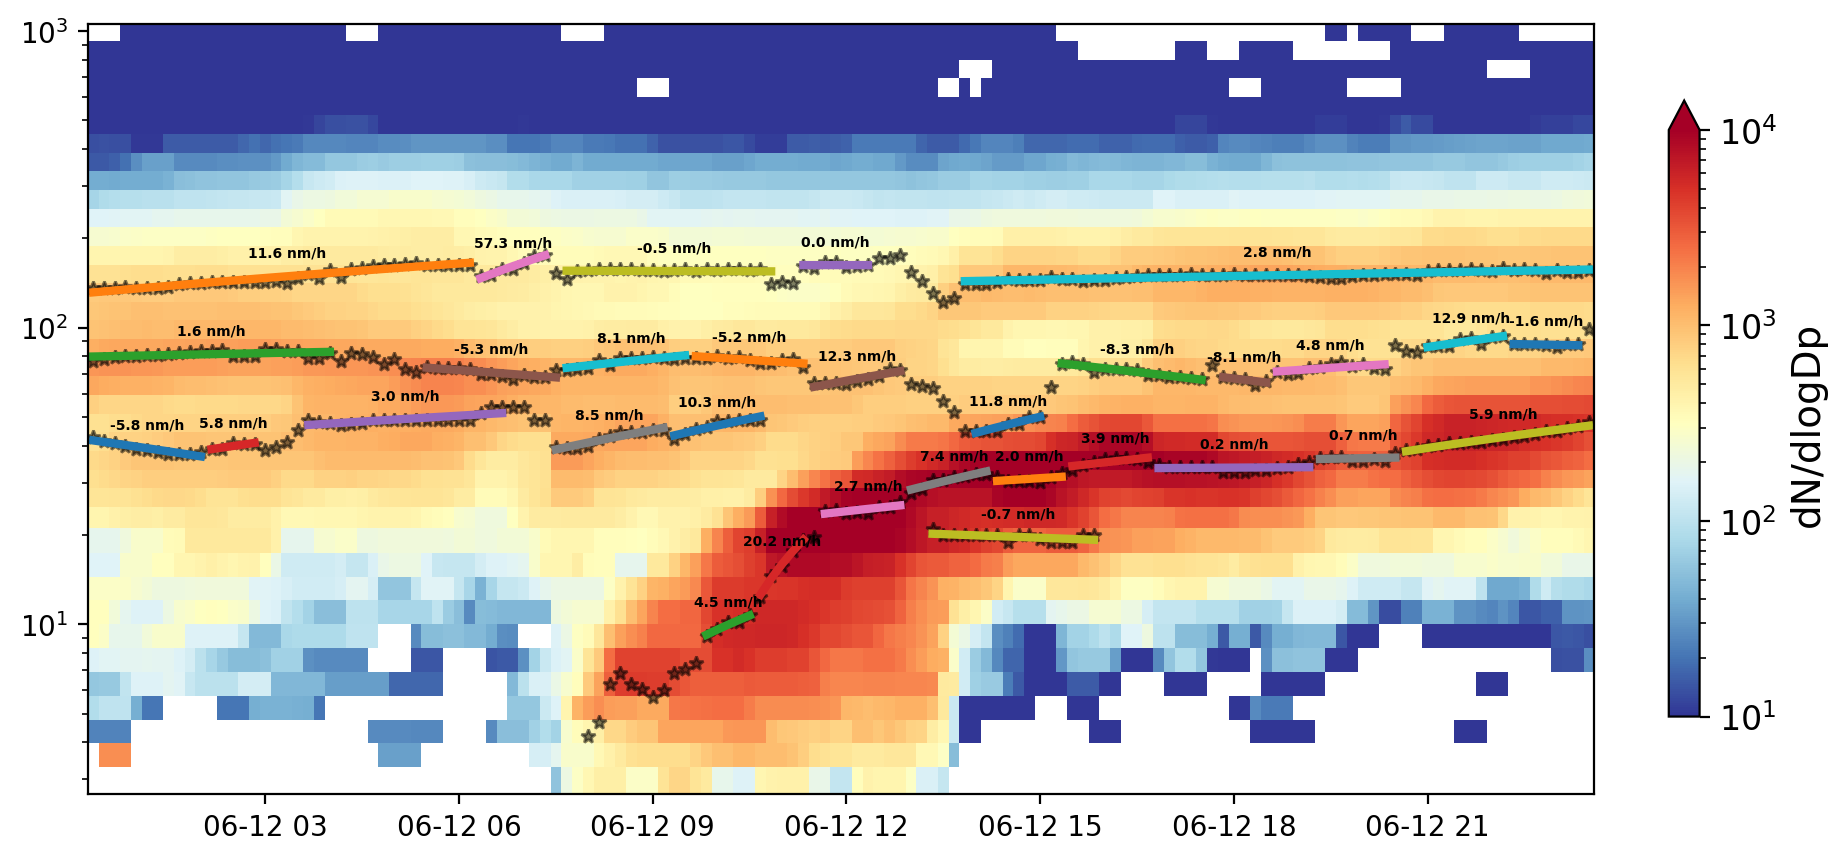

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue May  7 19:54:10 2024

@author: unfer
"""

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ruptures as rpt
from matplotlib import colors
from datetime import timedelta
from datetime import datetime
from scipy.optimize import curve_fit, OptimizeWarning 
import warnings
from scipy import stats
import os ###
from os import listdir ###

###################################################################
paths = "/Users/touqeergill/Desktop/dm160612.sum"
dados1= pd.read_csv(paths,sep='\s+',engine='python') ###steps to '\s+'
df1 = pd.DataFrame(dados1)
#dm160405.sum

"""
###ADDED
#user gives the amount of data files to plot and starting day
#assumes data files are in chronological order in the folder with consecutive days
def input_data():
    paths_list = []
    
    amount = input("How many days of data (number): ")
    file_name = input("Name of first data file: ")

    counter = 0
    for name in sorted(listdir(folder)):
        if name == file_name:
            paths_list.append(file_name)
            counter += 1
            continue
        elif counter > 0 and counter < int(amount):
            paths_list.append(name)
            counter += 1
            continue
        else:
            continue
    return paths_list
paths = input_data()

###modified from Janne's code "NpfEventAnalyzer.py":
### load data for n days: ###
def combine_data():
    dfs = []
    test = True
    #load all given data files and save them a list
    for i in paths:
        df = pd.DataFrame(pd.read_csv(folder + i,sep='\s+',engine='python'))
        #make sure all columns have the same diameter values, name all other columns with the labels of the first one
        if test == True:
            diameter_labels = df.columns
            test = False
        df.rename(columns=dict(zip(df.columns, diameter_labels)), inplace=True)
        dfs.append(df) #add dataframe to list
    #combine datasets
    combined_data = pd.concat(dfs,axis=0,ignore_index=True)
    return combined_data
df1 = combine_data()
"""
###----

diameters = df1.columns[2:].astype(float)*10**9 ### save diameters as floats before replacing them with new column names / units from m to nm
df1.columns = ["time (d)", "total number concentration (N)"] + [f"dN/dlogDp_{i}" for i in range(1,df1.shape[1]-1)] ###rename columns
time_d = df1.iloc[:,0].astype(float) ###ADDED save time as days before changing them to UTC 

### assuming time is in "days from start of measurement"
def days_into_UTC():
    time_steps = df1["time (d)"] - time_d[0]
    start_date_measurement = f"20{paths[-10:-8]}-{paths[-8:-6]}-{paths[-6:-4]} 00:00:00"
    start_date = datetime.strptime(start_date_measurement, "%Y-%m-%d %H:%M:%S")
    df1["time (d)"] = [start_date + timedelta(days=i) for i in time_steps] #converting timesteps to datetime
days_into_UTC() ###

df1.rename(columns={'time (d)': 'Timestamp (UTC)'}, inplace=True) ###CHANGE '# "datetime (UTC)"' -> 'time (d)'
df1['Timestamp (UTC)']=pd.to_datetime(df1['Timestamp (UTC)'], format="%Y-%m-%d %H:%M:%S")
df1.index=df1['Timestamp (UTC)']
df1 = df1.drop(['Timestamp (UTC)'], axis=1)


df1[(df1<0)] = 0                     ## Treat negative data as zero
df1[(df1.sum(axis=1)==0)] = np.nan   ## Discart a whole zero size distribution
df1 = df1.dropna()

df1 = df1.resample('10Min').mean().interpolate(method='time', limit_area='inside', limit=6) ###CHANGE 5Min -> 10Min CHECK FROM HERE UP

N_tot = list(df1["total number concentration (N)"]) ### save total number concentrations to a list
df1 = df1.drop(['total number concentration (N)'], axis=1) ### drop N_tot from the dataframe
#df1['N_tot'] = (df1.sum(axis=1)*0.0265) ### commented away
#df1[df1['N_tot']>df1['N_tot'].quantile(0.999)] = np.nan  ### commented away
#df1 = df1.dropna() ### commented away
#df1 = df1.drop(['N_tot'], axis=1) ### commented away
df1.columns = pd.to_numeric(diameters) ### rename columns back to diameters

### median filter
for i in df1.columns:
    #df1[i] = df1[i].rolling(window=3, center=True).median() ### window of 3 datapoints i.e. 1 neighbouring value
    df1[i] = df1[i].rolling(window=5, center=True).median() ### window of 5 datapoints i.e. 2 neighbouring value
df1.dropna(inplace=True)

#with this we can check the format
df1.to_csv('./combined_data.csv', sep=',', header=True, index=True, na_rep='nan')

##############################################################

path4=r"/Users/touqeergill/Desktop/output_modefit_2016_06.csv"
dados4= pd.read_csv(path4,sep=',')
df4 = pd.DataFrame(dados4)

df4.index = pd.to_datetime(df4['Timestamp (UTC)'])
df4 = df4.drop(['Timestamp (UTC)'],axis=1)
df4 = df4.drop(['flag'],axis=1)
df4 = df4.astype(float)

#df4[(df4['R2']<0.7)] = np.nan ### 0.8 -> 0.7 COMMENTED AWAY, filters away mode fitting values that dont have a high enough r^2 value


##############################################################
def place_modes(row):
    if row['m1_d'] >= 20 and row['m2_A'] == 0:
        row['m2_A'], row['m2_d'], row['m2_s'] = row['m1_A'], row['m1_d'], row['m1_s']
        row['m1_A'], row['m1_d'], row['m1_s'] = 0, 10, 1.1

    if row['m2_d'] < 20 and row['m1_A'] == 0:
        row['m1_A'], row['m1_d'], row['m1_s'] = row['m2_A'], row['m2_d'], row['m2_s']
        row['m2_A'], row['m2_d'], row['m2_s'] = 0, 20, 1.1

    if row['m3_d'] < 50 and row['m2_A'] == 0:
        row['m2_A'], row['m2_d'], row['m2_s'] = row['m3_A'], row['m3_d'], row['m3_s']
        row['m3_A'], row['m3_d'], row['m3_s'] = 0, 50, 1.1
        
    if row['m3_d'] > 100 and row['m4_A'] == 0:
        row['m4_A'], row['m4_d'], row['m4_s'] = row['m3_A'], row['m3_d'], row['m3_s']
        row['m3_A'], row['m3_d'], row['m3_s'] = 0, 50, 1.1

    return row

df4 = df4.apply(place_modes, axis=1)


def replace_zero_with_nan(row):
    for i in range(1, 5):  
        if row[f'm{i}_A'] == 0.00:
            row[f'm{i}_A'] = np.nan
            row[f'm{i}_d'] = np.nan
            row[f'm{i}_s'] = np.nan
    return row

df4 = df4.apply(replace_zero_with_nan, axis=1)
df_modes = df4.copy()

########################################################################
###### CMAP
def inter_from_256(x):
    return np.interp(x=x,xp=[0,255],fp=[0,1])

R = [255,0,5,12,28,46,74,107,144,193,229,249,255,253,246]
G = [250,116,175,184,149,107,57,36,28,24,37,80,140,205,244]
B = [250,163,227,246,218,161,89,52,39,29,26,25,27,21,63]

cdict = {
    'red':((0.0,inter_from_256(R[0]),inter_from_256(R[0])),
           (1/14*1,inter_from_256(R[1]),inter_from_256(R[1])),
           (1/14*2,inter_from_256(R[2]),inter_from_256(R[2])),
           (1/14*3,inter_from_256(R[3]),inter_from_256(R[3])),
           (1/14*4,inter_from_256(R[4]),inter_from_256(R[4])),
           (1/14*5,inter_from_256(R[5]),inter_from_256(R[5])),
           (1/14*6,inter_from_256(R[6]),inter_from_256(R[6])),
           (1/14*7,inter_from_256(R[7]),inter_from_256(R[7])),
           (1/14*8,inter_from_256(R[8]),inter_from_256(R[8])),
           (1/14*9,inter_from_256(R[9]),inter_from_256(R[9])),
           (1/14*10,inter_from_256(R[10]),inter_from_256(R[10])),
           (1/14*11,inter_from_256(R[11]),inter_from_256(R[11])),
           (1/14*12,inter_from_256(R[12]),inter_from_256(R[12])),
           (1/14*13,inter_from_256(R[13]),inter_from_256(R[13])),
           (1.0,inter_from_256(R[14]),inter_from_256(R[14]))),
    'green': ((0.0,inter_from_256(G[0]),inter_from_256(G[0])),
           (1/14*1,inter_from_256(G[1]),inter_from_256(G[1])),
           (1/14*2,inter_from_256(G[2]),inter_from_256(G[2])),
           (1/14*3,inter_from_256(G[3]),inter_from_256(G[3])),
           (1/14*4,inter_from_256(G[4]),inter_from_256(G[4])),
           (1/14*5,inter_from_256(G[5]),inter_from_256(G[5])),
           (1/14*6,inter_from_256(G[6]),inter_from_256(G[6])),
           (1/14*7,inter_from_256(G[7]),inter_from_256(G[7])),
           (1/14*8,inter_from_256(G[8]),inter_from_256(G[8])),
           (1/14*9,inter_from_256(G[9]),inter_from_256(G[9])),
           (1/14*10,inter_from_256(G[10]),inter_from_256(G[10])),
           (1/14*11,inter_from_256(G[11]),inter_from_256(G[11])),
           (1/14*12,inter_from_256(G[12]),inter_from_256(G[12])),
           (1/14*13,inter_from_256(G[13]),inter_from_256(G[13])),
           (1.0,inter_from_256(G[14]),inter_from_256(G[14]))),
    'blue': ((0.0,inter_from_256(B[0]),inter_from_256(B[0])),
           (1/14*1,inter_from_256(B[1]),inter_from_256(B[1])),
           (1/14*2,inter_from_256(B[2]),inter_from_256(B[2])),
           (1/14*3,inter_from_256(B[3]),inter_from_256(B[3])),
           (1/14*4,inter_from_256(B[4]),inter_from_256(B[4])),
           (1/14*5,inter_from_256(B[5]),inter_from_256(B[5])),
           (1/14*6,inter_from_256(B[6]),inter_from_256(B[6])),
           (1/14*7,inter_from_256(B[7]),inter_from_256(B[7])),
           (1/14*8,inter_from_256(B[8]),inter_from_256(B[8])),
           (1/14*9,inter_from_256(B[9]),inter_from_256(B[9])),
           (1/14*10,inter_from_256(B[10]),inter_from_256(B[10])),
           (1/14*11,inter_from_256(B[11]),inter_from_256(B[11])),
           (1/14*12,inter_from_256(B[12]),inter_from_256(B[12])),
           (1/14*13,inter_from_256(B[13]),inter_from_256(B[13])),
           (1.0,inter_from_256(B[14]),inter_from_256(B[14]))),
}

cmap = colors.LinearSegmentedColormap('new_cmap',segmentdata=cdict)
########################################################################

def calculate_slope(x, y):
    try:
        slope = np.polyfit(x, y, 1)[0]
        return slope
    except np.linalg.LinAlgError:
        return np.nan

def check_time_gaps(indices, max_gap_minutes):
    time_gaps = indices.to_series().diff()
    return (time_gaps > timedelta(minutes=max_gap_minutes)).any()

def fit_curve(data):
    def linear(x, m, b):
        return m * x + b
    x = np.arange(len(data))
    y = data.values
   
    try:
        popt, _ = curve_fit(linear, x, y)
        return linear, popt
    except:
        return None, None
    
###############################################

def find_segments(df,abr):
    segments = []
    timestamps = df.index
    
    for i in range(0, len(timestamps), 1):
        segments.append((timestamps[i]))
 
    return segments    

##################################################

def combine_segments(df, abr, segments, mape_threshold=2):
    combined_segments = []
    start = 0

    while start < len(segments):
        end = start + 1
        while end < len(segments):
            if end >= len(segments):
                break
            
            comb_segs_data = df[abr + '_d'].loc[segments[start]:segments[end]]
            time_difference = segments[end] - segments[end - 1]
            if time_difference != timedelta(minutes=10): ###checks if the time difference is not 5mins!!! CHANGED: timedelta(minutes=5) -> timedelta(minutes=10)
                break
            
            x_comb = np.arange(len(comb_segs_data))
            y_comb = comb_segs_data.values
            #print(comb_segs_data)
            curve, popt = fit_curve(comb_segs_data)
            y_fit = curve(x_comb, *popt)
            erros_absolutos = np.abs(y_fit - y_comb)
            mape = np.mean(erros_absolutos / y_comb) * 100
            
            if mape > mape_threshold:
                break
                       
            end += 1
              
        if len (comb_segs_data) == 3 and mape > mape_threshold:
            start = end-1
        else:           
            combined_segments.append((segments[start], segments[min(end-1, len(segments)-1)]))
            start = end 
        
    return combined_segments

###################################################

def filter_segments(df, abr, combined_segments):
    filtered_segments = []
    for segment in combined_segments:
        
        data = df[abr + '_d'].loc[segment[0]:segment[1]]
              
        if len(data) >= 5 and not check_time_gaps(df.loc[segment[0]:segment[1]].index, 120):
                
            curve, popt = fit_curve(data)
            if curve is not None and popt is not None:
                x_values = np.arange(len(data))
                y_values = data.values
                erros_absolutos = np.abs(curve(x_values, *popt) - y_values)
                mape = np.mean(erros_absolutos / y_values) * 100

                if mape <= 10:
                    filtered_segments.append(segment)
    return filtered_segments

########################

def process_data(df, abr):
    results = []

    df_subset = df[[abr + '_A', abr + '_d', abr + '_s']].copy()
    df_subset = df_subset.dropna()
  
    segs = find_segments(df_subset,abr)
    print('Segments done! (1/3)')
    comb_segs = combine_segments(df_subset, abr, segs)
    print('Combined segments done! (2/3)')
    filter_segs = filter_segments(df_subset, abr, comb_segs)
    print('Filtering done! (3/3)')
    results.append(filter_segs)    
 
    return df_subset, results

def extract_data (df_subset, results, abr):   
    print('Extracting dataframe...')
    lista = []
    segment_data = []
    fitted_curves = []

    for segment in results[0]:
       
        start = segment[0]
        end = segment[1]
        dt = ((end - start).total_seconds()) / 60
        
        d_initial = df_subset[abr + '_d'].loc[start]
        d_final = df_subset[abr + '_d'].loc[end]
        data = df_subset[abr + '_d'].loc[start:end]
        d_mean = data.mean()
        mean_A = df_subset[abr + '_A'].loc[start:end].mean()
        mean_s = df_subset[abr + '_s'].loc[start:end].mean()

        curve, popt = fit_curve(data)
        GR = popt[0] * 12 
        lista.append([start, end, dt, d_initial, d_final, round(d_mean,1), round(mean_A,2), round(mean_s,3), round(GR, 1)])
        segment_data.append(data)
        fitted_curves.append((curve, popt))
    
    df_GR = pd.DataFrame(lista)
    if len(df_GR)==0:
        pass
    else:      
        df_GR.rename(columns={0: 'start', 1: 'end', 2: 'dt', 3: 'd_initial', 4: 'd_final', 5: 'mean_d', 6: 'mean_A', 7: 'mean_s', 8: 'GR'}, inplace=True)
        df_GR.index = df_GR['start']
        df_GR = df_GR.drop(['start'],axis=1)
    return df_GR, segment_data, fitted_curves

###############################################################################

def plot(*args):
    fig, ax = plt.subplots(figsize=(12, 3), dpi=300)
    x = df1.index[0:]
    #y = df1.columns.astype(float) ### 
    y = diameters ###
    plt.pcolormesh(x, y, df1[0:].T, cmap='RdYlBu_r', zorder=0, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
    ax.set_yscale('log')
    cbar = plt.colorbar(orientation='vertical', shrink=0.8, extend="max", pad=0.04)
    cbar.set_label('dN/dlogDp', size=14)
    cbar.ax.tick_params(labelsize=12)
    
    for i in range(0, len(args), 4):
        abr = args[i]
        #df_GR = args[i + 1]
        segment_data = args[i + 2]
        fitted_curves = args[i + 3]
        
        if len(segment_data) > 0:  # Checks for segment data
            print("\nMode "+abr)
            plt.plot(df_modes.index, df_modes[abr + '_d'], '*', alpha=0.5, color='black', markersize=5)
        
        for j, data in enumerate(segment_data):
            if len(data) > 2:
                curve, popt = fitted_curves[j]
                if curve:
                    slope = round((popt[0] * 12), 1)
                    print(f"Segment {j + 1}: {slope} nm/h")
                    x_values = np.arange(len(data))
                    plt.plot(data.index, curve(x_values, *popt), lw=3)
               
                    midpoint_idx = len(data) // 2
                    midpoint_time = data.index[midpoint_idx]
                    midpoint_value = curve(midpoint_idx, *popt)
                    
                    plt.annotate(f'{slope} nm/h', (midpoint_time, midpoint_value), 
                                 textcoords="offset points", xytext=(0, 10), ha='center', fontsize=8, fontweight='bold')              
                else:
                    plt.plot(data.index, data, lw=3)
    
    plt.show()

############################################################################################

abr1 = 'm1'
print('\n'+'*********** Calculating GR for mode 1'+'\n')
df_subset_m1, results_m1 = process_data(df_modes, abr1)
df_GR_m1, segment_data_m1, fitted_curves_m1 = extract_data (df_subset_m1, results_m1, abr1)
#print(df_GR_m1)      ###

#df_GR_m1.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode1_nucl_data_v3.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1) # !!! Warning: make plots only for events or short dataset 

abr2 = 'm2'
print('\n'+'*********** Calculating GR for mode 2'+'\n')
df_subset_m2, results_m2 = process_data(df_modes, abr2)
df_GR_m2, segment_data_m2, fitted_curves_m2 = extract_data (df_subset_m2, results_m2, abr2)
#print(df_GR_m2)     ###
# df_GR_m2.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode2_ait1_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr2, df_GR_m2, segment_data_m2, fitted_curves_m2) # !!! Warning: make plots only for events or short dataset
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,abr2, df_GR_m2, segment_data_m2, fitted_curves_m2)

abr3 = 'm3'
print('\n'+'*********** Calculating GR for mode 3'+'\n')
df_subset_m3, results_m3 = process_data(df_modes, abr3)
df_GR_m3, segment_data_m3, fitted_curves_m3 = extract_data (df_subset_m3, results_m3, abr3)
#print(df_GR_m3)     ###
#df_GR_m3.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode3_ait2_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr3, df_GR_m3, segment_data_m3, fitted_curves_m3) # !!! Warning: make plots only for events or short dataset
#plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,abr2, df_GR_m2, segment_data_m2, fitted_curves_m2,abr3, df_GR_m3, segment_data_m3, fitted_curves_m3)

abr4 = 'm4'
print('\n'+'*********** Calculating GR for mode 4'+'\n')
df_subset_m4, results_m4 = process_data(df_modes, abr4)
df_GR_m4, segment_data_m4, fitted_curves_m4 = extract_data (df_subset_m4, results_m4, abr4)
#print(df_GR_m4)      ###
#df_GR_m4.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_mode4_acc_data.csv',sep=',',header=True, index=True,na_rep='nan')
#plot(abr4, df_GR_m4, segment_data_m4, fitted_curves_m4) # !!! Warning: make plots only for events or short dataset
# plot(abr1, df_GR_m1, segment_data_m1, fitted_curves_m1,
#       abr2, df_GR_m2, segment_data_m2, fitted_curves_m2,
#       abr3, df_GR_m3, segment_data_m3, fitted_curves_m3,
#       abr4, df_GR_m4, segment_data_m4, fitted_curves_m4)


############################################################################################
def drop_after_first_nan(df, column):
    """Drops rows after the first occurrence of NaN in a specific column."""
    first_nan_index = df[column].isna().idxmax()
    if pd.isna(df[column].loc[first_nan_index]):
        return df.loc[:first_nan_index].iloc[:-1]
    return df


def process_data2(dfA, m1, dfB, m2, diameter_diff):
    lista = []
    listaA_del = []
    listaB_del = []
 
    for j in range(0,len(dfA)):
        start1 = dfA.index[j]
        end1 = dfA['end'].iloc[j]   # !!!
               
        df_m1 = df_modes.loc[start1:end1, [m1+'_A', m1+'_d', m1+'_s']]
        df_m1.columns = ['m_A', 'm_d', 'm_s']
    
        start_target = dfA['end'].iloc[j] + pd.Timedelta(minutes=10) ### minutes=5 -> minutes=10
        #print(start_target)
        if start_target in dfB.index.values:
            #print(start_target)
            
            idx_position = dfB.index.get_loc(start_target)
            
            if (dfB['d_initial'].iloc[idx_position] - dfA['d_final'].iloc[j]) < diameter_diff:
            
                start2 = dfB.index[idx_position]       # !!!
                end2 = dfB['end'].iloc[idx_position]
                df_m2 = df_modes.loc[start2:end2, [m2+'_A', m2+'_d', m2+'_s']]
                df_m2.columns = ['m_A', 'm_d', 'm_s']
                         
                df_comb1 = pd.concat([df_m1, df_m2], axis=0)
                
                x_comb = np.arange(len(df_comb1))
                y_comb = df_comb1['m_d']
             
                curve, popt = fit_curve(y_comb)
                y_fit = curve(x_comb, *popt)
                erros_absolutos = np.abs(y_fit - y_comb)
                mape1 = np.mean(erros_absolutos / y_comb) * 100
                #print(mape1)
                if mape1 <= 3:
                    if idx_position + 1 < len(dfB) and (dfB.index[idx_position + 1] - dfB['end'].iloc[idx_position] > pd.Timedelta(minutes=10)): ### minutes=5 -> minutes=10
                        
                        df_m2_next = df_modes.loc[start2:(dfB.index[idx_position + 1] - pd.Timedelta(minutes=10)), [m2+'_A', m2+'_d', m2+'_s']] ### minutes=5 -> minutes=10
                        df_m2_next.columns = ['m_A', 'm_d', 'm_s']
                        df_comb2 = pd.concat([df_m1, df_m2_next], axis=0)
                        #print(df_comb2)
                        
                        df_comb2 = drop_after_first_nan(df_comb2, 'm_d')
                        
                        x_comb = np.arange(len(df_comb2))
                        y_comb = df_comb2['m_d']
                        curve, popt = fit_curve(y_comb)
                        y_fit = curve(x_comb, *popt)
                        erros_absolutos = np.abs(y_fit - y_comb)
                        mape2 = np.mean(erros_absolutos / y_comb) * 100
                                       
                        if abs(mape1 - mape2) < 0.5:
                            df_comb = df_comb2
                        else:
                            df_comb = df_comb1
                    else:
                        df_comb = df_comb1
                    
                    start = df_comb.index[0]
                    end = df_comb.index[-1]
                    dt = ((end - start).total_seconds()) / 60
                                        
                    d_initial = df_comb['m_d'].loc[start]
                    d_final = df_comb['m_d'].loc[end]
                    d_mean = df_comb['m_d'].mean()
                  
                    mean_A = df_comb['m_A'].mean()
                    mean_s = df_comb['m_s'].mean()
                    
                    curve, popt = fit_curve(df_comb['m_d'])
                    GR = popt[0] * 12  
                    mode = m1+'_'+m2
                
                    lista.append([start, end, dt, d_initial, d_final, round(d_mean,1), round(mean_A, 2), round(mean_s, 3), round(GR, 1), mode])               
                    listaA_del.append(dfA.index[j])
                    listaB_del.append(dfB.index[idx_position])
                
                else:
                    lista.append([np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan,np.nan])
                    continue  
        else:
            pass
  
    if lista:
        
        dfA_new = dfA.drop(listaA_del)
        dfA_new['mode'] = m1
        
        dfB_new = dfB.drop(listaB_del)
        dfB_new['mode'] = m2
             
        df_comb_all = pd.DataFrame(lista, columns=['start', 'end', 'dt', 'd_initial', 'd_final', 'mean_d', 'mean_A', 'mean_s', 'GR', 'mode'])
        df_comb_all.set_index('start', inplace=True)
        df_comb_all = df_comb_all.dropna()
    
        
        df_all = pd.concat([df_comb_all, dfA_new, dfB_new]).sort_index()
        df_new = dfB_new

    else:   
        dfA['mode'] = m1
        dfB['mode'] = m2
        df_all = pd.concat([dfA, dfB]).sort_index()
        df_new = dfB
        df_comb_all = np.nan
               
    return df_all, df_new, df_comb_all

###############################################################################
print('Checking modes 1 and 2...')
df_all1, df_new2, df_del = process_data2(df_GR_m1,'m1', df_GR_m2, 'm2', 3)
df_all1.insert(0,'start',df_all1.index)
df_all1 = df_all1.reset_index(drop=True)
print(df_all1)

print('Checking modes 2 and 3...')
df_all2, df_new3, df_del = process_data2(df_new2,'m2', df_GR_m3, 'm3', 5)
df_all2.insert(0,'start',df_all2.index)
df_all2 = df_all2.reset_index(drop=True)
print(df_all2)

print('Checking modes 3 and 4...')
df_all3, _, df_del = process_data2(df_new3,'m3', df_GR_m4, 'm4', 10)
df_all3.insert(0,'start',df_all3.index)
df_all3 = df_all3.reset_index(drop=True)
print(df_all3)

###################

df_all1_m2 = df_all1[df_all1['mode'] == 'm2']
df_all2_m2 = df_all2[df_all2['mode'] == 'm2']

# Identificar as linhas no df_all1_m2 que não estão presentes no df_all2_m2
to_remove = df_all1_m2[~df_all1_m2.apply(tuple, axis=1).isin(df_all2_m2.apply(tuple, axis=1))]
# Excluir as linhas identificadas do df_all1
df_all1_filtered = df_all1.drop(to_remove.index)

###

df_all2_m3 = df_all2[df_all2['mode'] == 'm3']
df_all3_m3 = df_all3[df_all3['mode'] == 'm3']

# Identificar as linhas no df_all1_m2 que não estão presentes no df_all2_m2
to_remove = df_all2_m3[~df_all2_m3.apply(tuple, axis=1).isin(df_all3_m3.apply(tuple, axis=1))]
# Excluir as linhas identificadas do df_all1
df_all2_filtered = df_all2.drop(to_remove.index)


###################

df_GR_final = pd.concat([df_all1_filtered,df_all2_filtered,df_all3],axis=0,ignore_index=True)
df_GR_final = df_GR_final.drop_duplicates()
df_GR_final.index = df_GR_final['start']
df_GR_final = df_GR_final.drop(columns=['start'])
df_GR_final = df_GR_final.sort_index()

print(df_GR_final)
#df_GR_final.to_csv(r'C:\Users\unfer\Desktop\To_new_PC\PhD\Data\GR\GR_allmodes.csv',sep=',',header=True, index=True,na_rep='nan')


###############################################################################

def plot2(df):
    fig, ax = plt.subplots(figsize=(12, 5), dpi=200) ### figsize=(12, 3), dpi=300 -> figsize=(12, 5), dpi=200

    x = df1.index[0:]
    y = df1.columns.astype(float)
    plt.pcolormesh(x, y, df1[0:].T, cmap='RdYlBu_r', zorder=0, norm=colors.LogNorm(vmin=1e1, vmax=1e4))
    ax.set_yscale('log')
    cbar = plt.colorbar(orientation='vertical', shrink=0.8, extend="max", pad=0.04)
    cbar.set_label('dN/dlogDp', size=14)
    cbar.ax.tick_params(labelsize=12)
    #print("df_modes 2:",df_modes) ###
    
    
    plt.plot(df_modes.index, df_modes['m1_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m2_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m3_d'], '*', alpha=0.5, color='black', markersize=5)
    plt.plot(df_modes.index, df_modes['m4_d'], '*', alpha=0.5, color='black', markersize=5)
    
    
    for j in range (0,len(df)):
        
        abr = df['mode'].iloc[j]
             
        if abr == 'm1_m2' or abr == 'm2_m3' or abr == 'm3_m4':
            
            parts = df['mode'].iloc[j].split('_')         
            abr1 = parts[0]
            start1 = df.index[j]
            end1 = df['end'].iloc[j]
            data1 = df_modes[abr1+'_d'].loc[start1:end1]
             
            abr2 = parts[1]
            start2 = df.index[j]
            end2 = df['end'].iloc[j]
            data2 = df_modes[abr2+'_d'].loc[start2:end2]
            
            ####
            df_n = pd.concat([data1,data2],axis=1)
            df_n.index = data1.index
            #print(df)
 
            for i in range (0,len(df_n)-1):
                
                d1 = df_n[abr1+'_d'].iloc[i]
                d2 = df_n[abr2+'_d'].iloc[i+1]
                
                if d2-d1 < 5:
                    data1 = df_n[abr1+'_d'].iloc[0:i]
                    data2 = df_n[abr2+'_d'].iloc[i+1:]
                    
                    data = pd.concat([data1,data2],axis=0)
                    #print(data)
        
        else:
          
            abr = df['mode'].iloc[j]
            start = df.index[j]
            end = df['end'].iloc[j]
            data = df_modes[abr+'_d'].loc[start:end]
            #print(data)
            
        curve, popt = fit_curve(data)
        #print(curve)
                  
        slope = round((popt[0] * 12), 1)
        x_values = np.arange(len(data))
        plt.plot(data.index, curve(x_values, *popt), lw=3) 
   
        midpoint_idx = len(data) // 2
        midpoint_time = data.index[midpoint_idx]
        midpoint_value = curve(midpoint_idx, *popt)
        
        plt.annotate(f'{slope} nm/h', (midpoint_time, midpoint_value), 
                     textcoords="offset points", xytext=(0, 7), ha='center', fontsize=5, fontweight='bold') ### xytext=(0, 10) -> xytext=(0, 7) & fontsize=8 -> fontsize=5               
      
    plt.show() ###
    return curve ###added to save curvefit values 
    
plot2(df_GR_final) ###
#modefit_points = plot2(df_GR_final) ###added to save curvefit values 
df_GR_final.to_csv('./Gr_final.csv', sep=',', header=True, index=True, na_rep='nan')


